In [3]:
# --- Model Evaluation Notebook ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir("/Users/gagigetsadze/Desktop/Python programs/Time_Series_Pred")
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
from features.build_features import FeatureEngineering

from models.baseline import PersistenceModel
from models.arima import ARIMAModel
from models.prophet import ProphetModel
from models.lstm import LSTMModel
from models.xgboost_model import XGBoostModel
from models.model_utils import evaluate_model, plot_predictions
from sklearn.metrics import mean_squared_error
from scipy.stats import norm


/Users/gagigetsadze/Desktop/Python programs/Time_Series_Pred/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [4]:
# Project Directory Setup (adjust as necessary)
project_dir = os.getcwd()
raw_data_dir = os.path.join(project_dir, "data", "raw", "1023")

In [5]:
# Load Data
def load_data(filepath):
    try:
        df = pd.read_csv(filepath)
        print(f"Successfully loaded data from: {filepath}")
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None
    except Exception as e:
        print(f"An error occurred loading data: {e}")
        return None

In [6]:
sp500_companies_path = os.path.join(raw_data_dir, "sp500_companies.csv")
sp500_index_path = os.path.join(raw_data_dir, "sp500_index.csv")
sp500_stocks_path = os.path.join(raw_data_dir, "sp500_stocks.csv")

sp500_companies_df = load_data(sp500_companies_path)
sp500_index_df = load_data(sp500_index_path)
sp500_stocks_df = load_data(sp500_stocks_path)
sp500_stocks_df['Date'] = pd.to_datetime(sp500_stocks_df['Date'])

Successfully loaded data from: /Users/gagigetsadze/Desktop/Python programs/Time_Series_Pred/data/raw/1023/sp500_companies.csv
Successfully loaded data from: /Users/gagigetsadze/Desktop/Python programs/Time_Series_Pred/data/raw/1023/sp500_index.csv
Successfully loaded data from: /Users/gagigetsadze/Desktop/Python programs/Time_Series_Pred/data/raw/1023/sp500_stocks.csv


In [7]:
def preprocess_stocks_data(sp500_stocks_df):
    if sp500_stocks_df is None:
        return None
    sp500_stocks_df = sp500_stocks_df.dropna(subset=["Adj Close"])
    sp500_stocks_df = sp500_stocks_df.sort_values(by="Date").reset_index(drop=True)
    return sp500_stocks_df

In [8]:
def create_and_merge_features(sp500_stocks_df, sp500_companies_df):
    if sp500_stocks_df is None:
        return None
    feature_eng = FeatureEngineering()
    lags_to_use = [1, 7, 30]
    sp500_stocks_df = feature_eng.create_lag_features(
        sp500_stocks_df, "Adj Close", lags_to_use
    )
    windows_to_use = [7, 30, 90]
    sp500_stocks_df = feature_eng.create_rolling_features(
        sp500_stocks_df, "Adj Close", windows_to_use
    )
    sp500_stocks_df = feature_eng.create_calendar_features(sp500_stocks_df, "Date")
    sp500_stocks_df = feature_eng.merge_company_data(
        sp500_stocks_df, sp500_companies_df
    )
    return sp500_stocks_df

In [9]:
def split_data(sp500_stocks_df):
    if sp500_stocks_df is None:
        return None, None, None
    feature_eng = FeatureEngineering()
    train_data, val_data, test_data = feature_eng.time_series_split(
        sp500_stocks_df, "Date"
    )
    return train_data, val_data, test_data

In [10]:
sp500_stocks_df = preprocess_stocks_data(sp500_stocks_df)
sp500_stocks_df = create_and_merge_features(sp500_stocks_df, sp500_companies_df)
train_data, val_data, test_data = split_data(sp500_stocks_df)

Merged the stock data with company data based on Symbol column.
Data has been split in a time-based fashion.


In [11]:
# Model Training and Prediction
def train_and_predict(model, model_name, train_data, test_data, val_data=None):
    print(f"\n--- {model_name} ---")
    if model_name == "Persistence":
        model.train(train_data)  # Persistence model doesn't train
        predictions = model.predict(test_data)
        return predictions
    elif model_name == "LSTM":
        model.train(train_data, val_data, target_column="Adj Close")
        if model.trained:
            predictions = model.predict(test_data, target_column="Adj Close")
            return predictions
    else:
        model.train(train_data, target_column="Adj Close", val_data=val_data)
        if model.trained:
            predictions = model.predict(test_data, target_column="Adj Close")
            return predictions
    return None


--- Persistence ---
Persistence model doesn't train, using last known values.

--- ARIMA ---
ARIMA model has been trained.

--- Prophet ---


20:00:17 - cmdstanpy - INFO - Chain [1] start processing
20:00:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet model has been trained.

--- LSTM ---
Epoch: 1/100, Training Loss:0.0218, Validation Loss: 0.0309
Epoch: 2/100, Training Loss:0.0233, Validation Loss: 0.0312
Epoch: 3/100, Training Loss:0.0221, Validation Loss: 0.0307
Epoch: 4/100, Training Loss:0.0229, Validation Loss: 0.0312
Epoch: 5/100, Training Loss:0.0222, Validation Loss: 0.0308
Epoch: 6/100, Training Loss:0.0228, Validation Loss: 0.0310
Epoch: 7/100, Training Loss:0.0231, Validation Loss: 0.0311
Epoch: 8/100, Training Loss:0.0213, Validation Loss: 0.0302
Epoch: 9/100, Training Loss:0.0220, Validation Loss: 0.0307
Epoch: 10/100, Training Loss:0.0231, Validation Loss: 0.0313
Epoch: 11/100, Training Loss:0.0211, Validation Loss: 0.0304
Epoch: 12/100, Training Loss:0.0211, Validation Loss: 0.0303
Epoch: 13/100, Training Loss:0.0218, Validation Loss: 0.0305
Epoch: 14/100, Training Loss:0.0209, Validation Loss: 0.0303
Epoch: 15/100, Training Loss:0.0229, Validation Loss: 0.0311
Epoch: 16/100, Training Loss:0.0230, Validation 

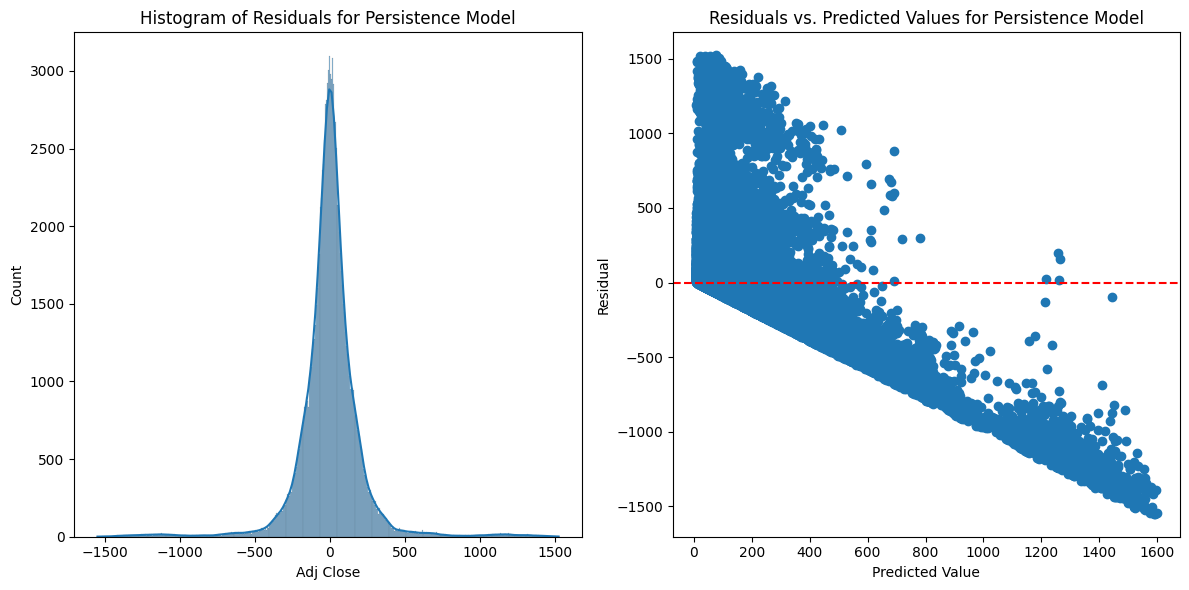

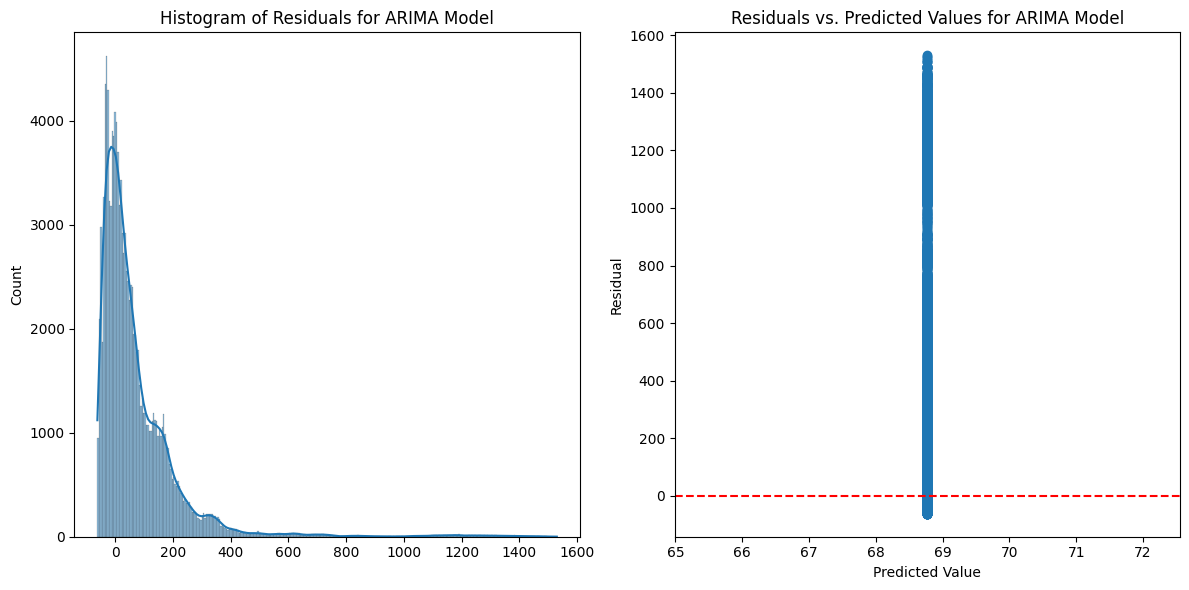

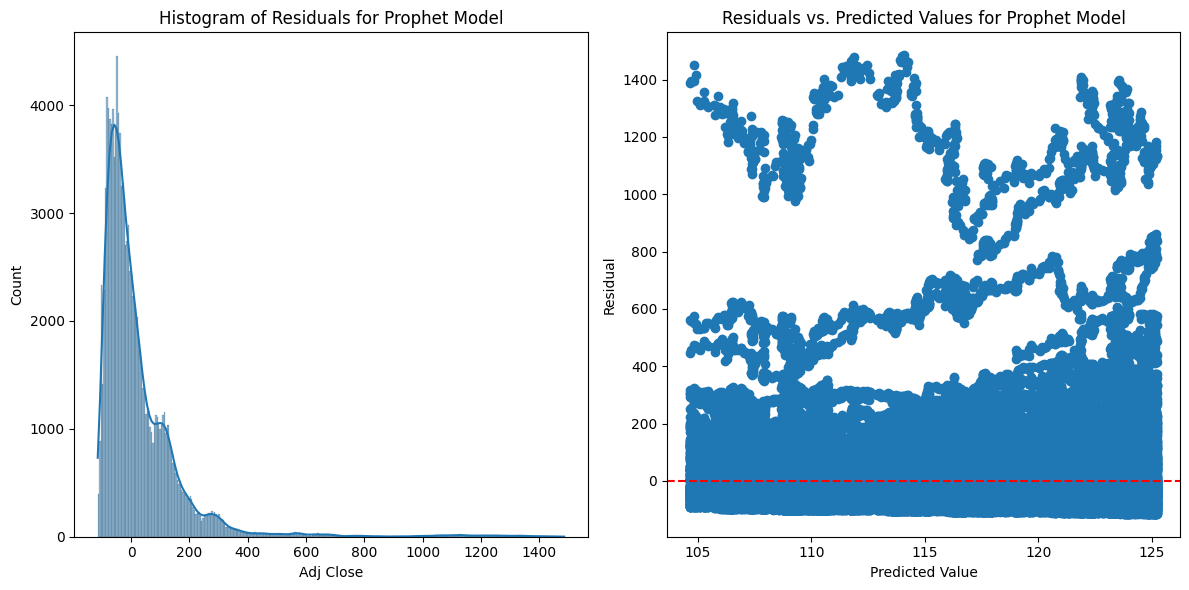

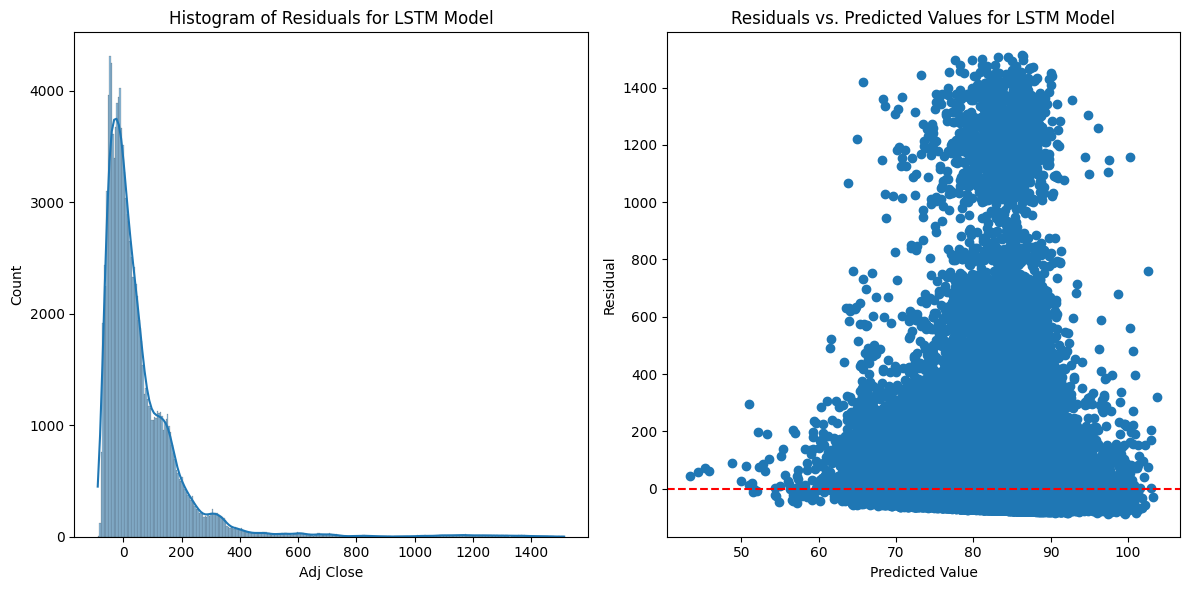

Persistence model doesn't train, using last known values.
Persistence model doesn't train, using last known values.
Persistence model doesn't train, using last known values.
Persistence model doesn't train, using last known values.
Persistence model doesn't train, using last known values.
Persistence model doesn't train, using last known values.
Persistence model doesn't train, using last known values.
Persistence model doesn't train, using last known values.
Persistence model doesn't train, using last known values.
Persistence model doesn't train, using last known values.
Persistence model doesn't train, using last known values.
Persistence model doesn't train, using last known values.
Persistence model doesn't train, using last known values.
Persistence model doesn't train, using last known values.
Persistence model doesn't train, using last known values.
Persistence model doesn't train, using last known values.
Persistence model doesn't train, using last known values.
Persistence mo

KeyboardInterrupt: 

In [12]:
if train_data is not None:
    # Train and predict with all models
    persistence_predictions = train_and_predict(
        PersistenceModel(), "Persistence", train_data, test_data
    )
    arima_predictions = train_and_predict(
        ARIMAModel(order=(5, 1, 0)), "ARIMA", train_data, test_data
    )
    prophet_predictions = train_and_predict(
        ProphetModel(), "Prophet", train_data, test_data
    )
    lstm_predictions = train_and_predict(
        LSTMModel(), "LSTM", train_data, test_data, val_data
    )
    xgboost_predictions = train_and_predict(
        XGBoostModel(), "XGBoost", train_data, test_data, val_data
    )

    # 1. Residual Analysis
    def plot_residuals(y_true, y_pred, model_name):
            residuals = y_true - y_pred
            plt.figure(figsize=(12,6))
            plt.subplot(1,2,1)
            sns.histplot(residuals, kde = True)
            plt.title(f'Histogram of Residuals for {model_name}')

            plt.subplot(1,2,2)
            plt.scatter(y_pred, residuals)
            plt.axhline(0, color='red', linestyle='--')
            plt.xlabel('Predicted Value')
            plt.ylabel('Residual')
            plt.title(f"Residuals vs. Predicted Values for {model_name}")

            plt.tight_layout()
            plt.show()


    if persistence_predictions is not None:
        plot_residuals(test_data["Adj Close"].iloc[1:], persistence_predictions.iloc[1:], "Persistence Model")
    if arima_predictions is not None:
        plot_residuals(test_data["Adj Close"], arima_predictions, "ARIMA Model")
    if prophet_predictions is not None:
        plot_residuals(test_data["Adj Close"], prophet_predictions, "Prophet Model")
    if lstm_predictions is not None:
        plot_residuals(test_data["Adj Close"].iloc[10:], lstm_predictions, "LSTM Model")
    if xgboost_predictions is not None:
        plot_residuals(test_data["Adj Close"], xgboost_predictions, "XGBoost Model")


    # 2. Rolling Forecast Analysis
    def rolling_forecast(model, model_name, train_data, test_data, window_size=30):
        predictions = []
        history = train_data.copy()
        test_values = test_data['Adj Close'].values
        for i in range(len(test_data)):
            if model_name == 'Persistence':
                model.train(history)
                yhat = model.predict(test_data.iloc[[i]])
            elif model_name == 'LSTM':
                model.train(history, val_data, target_column = "Adj Close")
                yhat = model.predict(test_data.iloc[[i]], target_column="Adj Close")

            else:
                model.train(history, target_column="Adj Close")
                yhat = model.predict(test_data.iloc[[i]], target_column="Adj Close")
            predictions.append(yhat)
            history = pd.concat([history, test_data.iloc[[i]]])
            if len(history) > len(train_data):
                history = history.iloc[1:] # rolling window


        predictions = np.array(predictions).flatten()
        test_values = test_values[:len(predictions)] # adjust test values length to match length of predictions

        mae, rmse, mape = evaluate_model(test_values, predictions)
        print(f"Rolling Forecast evaluation for {model_name} (MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE:{mape:.2f})")
        plot_predictions(pd.Series(test_values), pd.Series(predictions), model_name=f'{model_name} Rolling Forecast')

    if train_data is not None:
        rolling_forecast(PersistenceModel(), "Persistence", train_data, test_data)
        rolling_forecast(ARIMAModel(order = (5,1,0)), 'ARIMA', train_data, test_data)
        rolling_forecast(ProphetModel(), 'Prophet', train_data, test_data)
        rolling_forecast(LSTMModel(), "LSTM", train_data, test_data, val_data)
        rolling_forecast(XGBoostModel(), "XGBoost", train_data, test_data, val_data)